# Hierarchical Clustering
**Written by Christian Alis**

Representative-based clustering methods are flat clustering methods. You tell them to cluster data points into $k$ clusters and they will assign a point into exactly one cluster. Hierarchical clustering methods, on the other hand, assign points to a branch of a tree. Instead of having a priori value of $k$, it can be set after analysis, depending on where in the tree (hierarchy) you want to be.

There are two main types of hierarchical clustering:
* **Agglomerative clustering**: bottom-up approach where smaller clusters are merged with nearby clusters
* **Divisive clustering**: top-down approach where clusters are successively partitioned into smaller clusters

In this notebook, we will study four agglomerative clustering methods.

# Sample datasets

We will make use of the same datasets we investigated last time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.testing.compare import compare_images
from sklearn.datasets import load_wine, fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from IPython.display import HTML

In [2]:
data_wine = load_wine()
standard_scaler = StandardScaler()
X_wine = standard_scaler.fit_transform(data_wine['data'])
target_wine = data_wine['target']

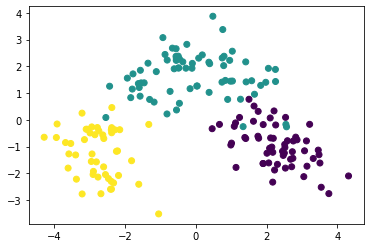

In [3]:
X_wine_new = PCA(n_components=2, random_state=1337).fit_transform(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=target_wine);

In [4]:
data_newsgroups = fetch_20newsgroups(
    subset='train', 
    categories=['comp.graphics', 'rec.autos'],
    shuffle=False, 
    remove=['headers', 'footers', 'quotes'])
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[a-z-]+', 
                                   stop_words='english',
                                   min_df=5)
bow_ng = tfidf_vectorizer.fit_transform(data_newsgroups['data'])
nonzeros = bow_ng.sum(axis=1).nonzero()[0]
bow_ng = bow_ng[nonzeros]
target_ng = data_newsgroups['target'][nonzeros]

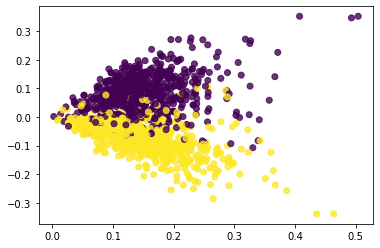

In [5]:
X_ng_new = (TruncatedSVD(n_components=2, random_state=1337)
                .fit_transform(bow_ng))
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=target_ng, alpha=0.8);

# Agglomerative clustering

This is the generic agglomerative clustering algorithm:

**Algorithm** *AgglomerativeClustering*(Database: $D$)  
**begin**  
$\quad$Initialize $n \times n$ distance metric $M$ using $D$;  
$\quad$Assign each $i \in D$ to its own cluster;  
$\quad$**repeat**  
$\quad$$\quad$Pick closest pair of clusters $i$ and $j$ using $M$;  
$\quad$$\quad$Merge clusters $i$ and $j$;  
$\quad$$\quad$Delete rows/columns $i$ and $j$ from $M$ and create a new row and column for newly merged cluster;  
$\quad$$\quad$Update the entries of new row and column of $M$;  
$\quad$**until** termination criterion;  
$\quad$**return** clustering;  
**end**

Different agglomerative clustering methods differ on how they compute the distance between clusters. The different cluster distance measures are:

* **Change in SSE**: increase in the sum-of-squared errors when the clusters are merged
* **Single linkage**: smallest distance between a point from one cluster to any point in the other cluster
* **Complete linkage**: farthest distance between a point from one cluster to any point in the other cluster
* **Group-average linkage**: average intercluster distance
* **Centroid**: distance between cluster centroids
* **Change in cluster variance**: increase in the objective function (cluster variance) when the clusters are merged

We will only discuss the first four measures in this notebook.

## Ward's method

The first agglomerative method that we will study is Ward's method. This method defines the distance between two clusters, $A$ and $B$, as the amount the sum of squares will increase when we merge them:

$$
\Delta(A, B) = \sum_{i \in A \bigcup B} \|x_i - m_{A \bigcup B}\|^2 - \sum_{i \in A} \|x_i - m_A\|^2 - \sum_{i \in B} \|x_i - m_B\|^2
$$

where $m_j$ is the center of cluster $j$, and $n_j$ is the number of points in it. $\Delta$ is the merging cost of combining the clusters $A$ and $B$. Starting from individual points as a cluster, the method merges them while trying to minimize the growth of $\Delta$. Given two pairs of clusters whose centers are equally far apart, Ward’s method will prefer to merge the smaller ones. Note that $\Delta$ always increases when we merge clusters.

We apply it to the wines dataset.

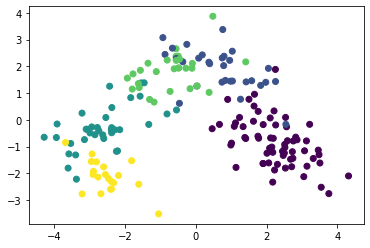

In [6]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=5)
y_predict_wine = agg.fit_predict(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

A benefit of hierarchical clustering is that the number of clusters can be changed after performing the clustering. The number of clusters is usually selected based on a visualization (dendrogram) of the clustering hierarchy. Unfortunately, there's no function that we can use to plot the dendrogram of the `AgglomerativeClustering` class. Thus, we will use `scipy.cluster.hierarchy` functions for clustering and plotting the dendrogram.

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_wine, method='ward', optimal_ordering=True)

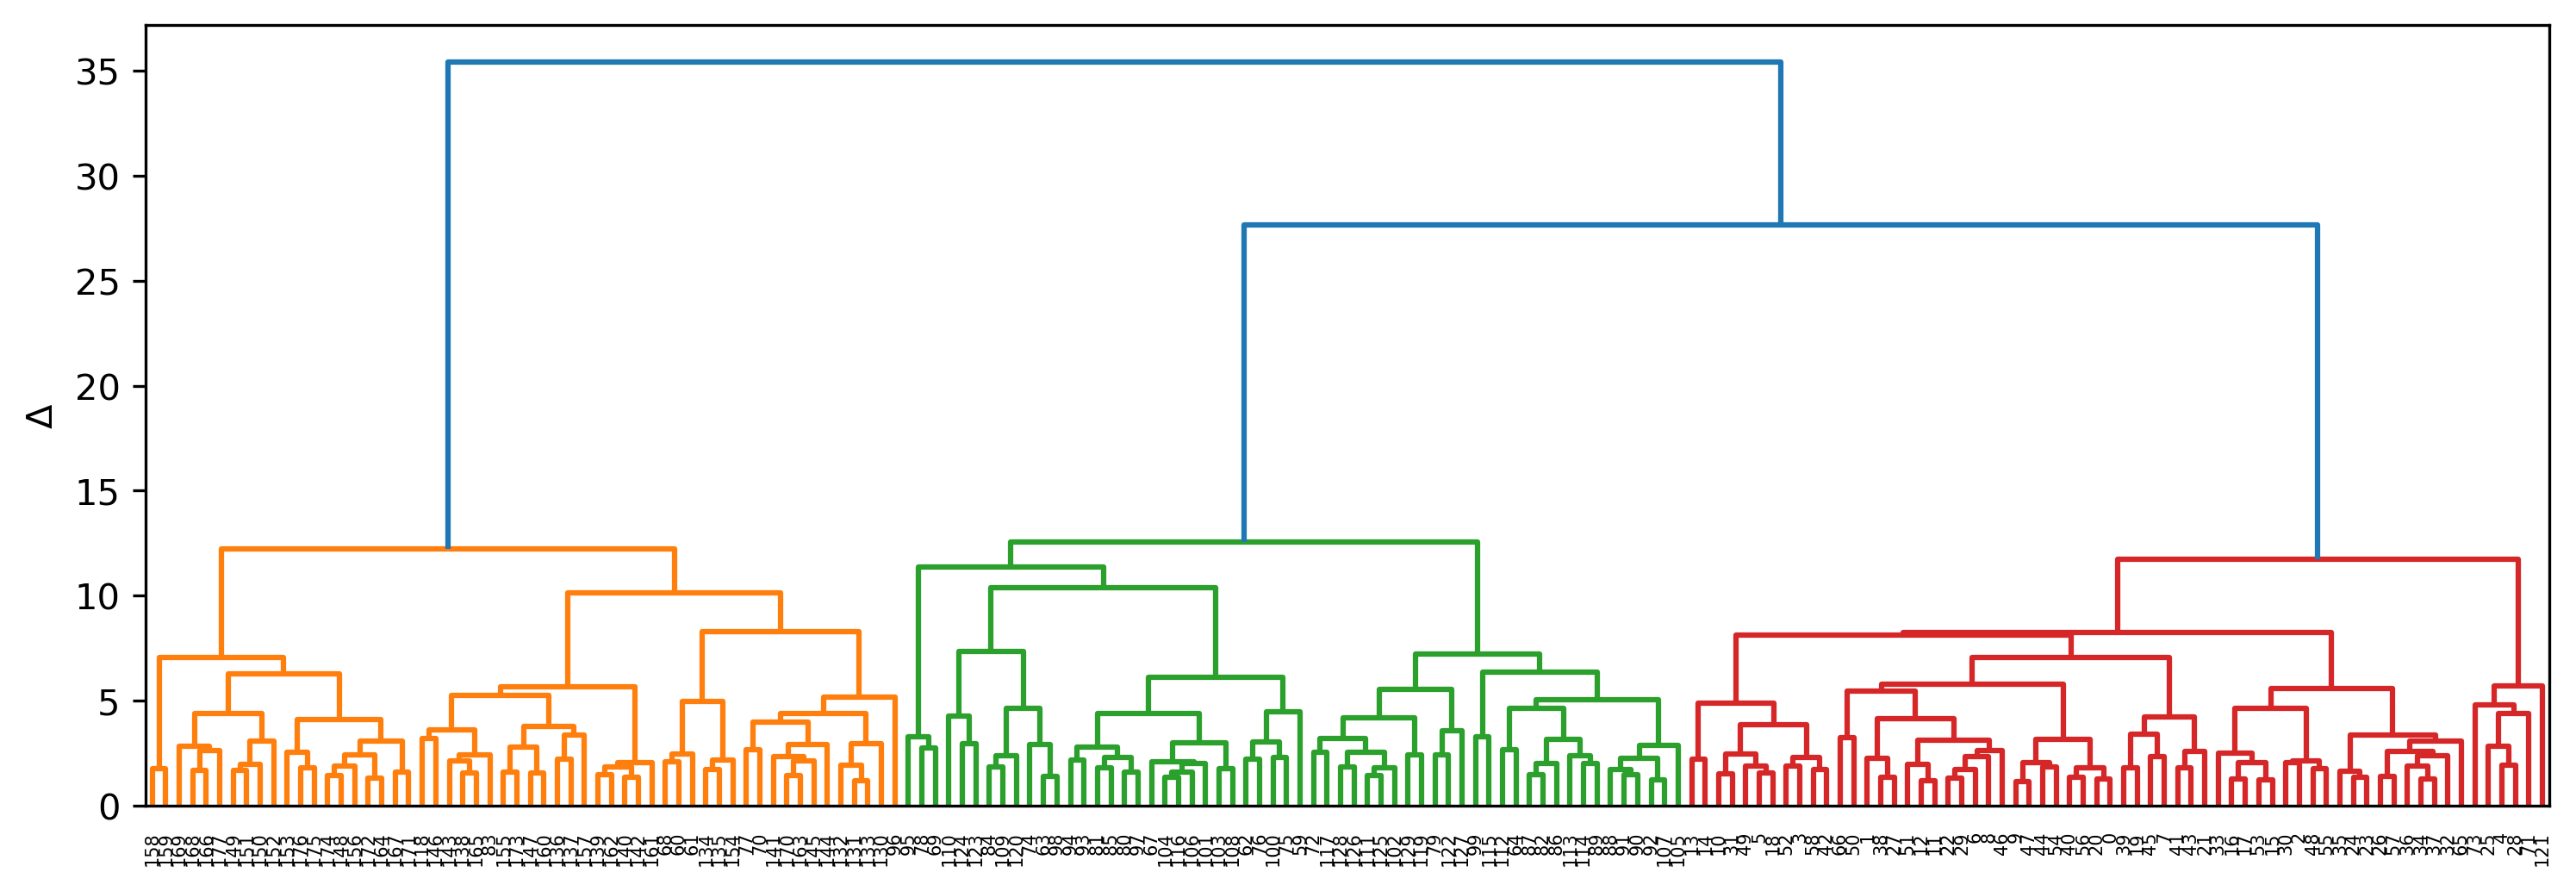

In [8]:
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$\Delta$');

The dendrogram is too crowded so let's try to clean it up a bit.

**Exercise 14**

Create a function `plot1` that accepts the output of linkage and replicates the plot below.

![](plot1.png)

In [9]:
Z = linkage(X_wine, method='average', optimal_ordering=True)


def plot1(Z):
    fig, ax = plt.subplots(figsize=(6, 4))
    dn = dendrogram(Z, truncate_mode='level', p=5, ax=ax)
    ax.set_ylabel(r'$\Delta$')
    return ax

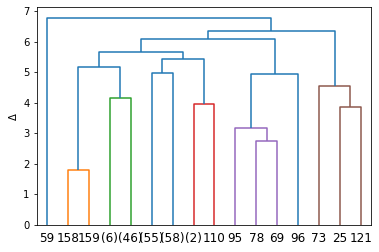

In [10]:
ax = plot1(Z)
ax.figure.savefig('plot1-test.png')
assert compare_images('plot1.png', 'plot1-test.png', tol=50) is None

We assign each point to a flat cluster using `fcluster`.

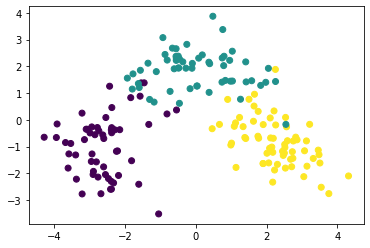

In [11]:
from scipy.cluster.hierarchy import fcluster
Z = linkage(X_wine, method='ward', optimal_ordering=True)
y_predict_wine = fcluster(Z, t=25, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 15**

Cluster the newsgroups dataset using Ward's method. What's the best value of $k$? Justify your answer.

In order to be able to perform clustering, we first perform latent semantic analysis on the resulting bag of words data matrix to decompose `bow_ng` and perform agglomerative clustering on the transformed dataset.

Note that the first 722 singular values explain 90% of the variation in the resulting tf-idf matrix of the newsgroups dataset. For this exercise, we perform clustering on the first 1000 singular values.

In [12]:
ng_svd = TruncatedSVD(n_components=1000, random_state=1337)
X_ng_new = ng_svd.fit_transform(bow_ng)

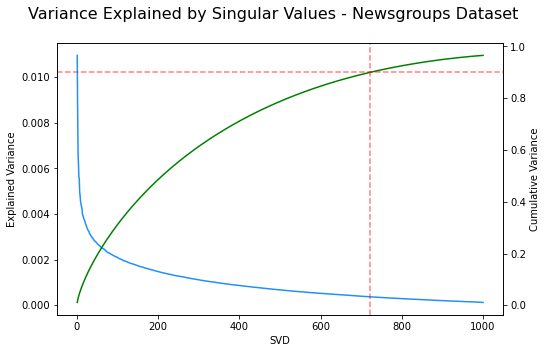

In [13]:
exp_var = np.array(sorted(ng_svd.explained_variance_, reverse=True))
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(list(range(1, 1001)), exp_var, color='dodgerblue')
ax1.set_ylabel('Explained Variance')
ax1.set_xlabel('SVD')
ax2 = ax1.twinx()
ax2.plot(list(range(1, 1001)), exp_var.cumsum(), color='green')
ax2.set_ylabel('Cumulative Variance')
plt.suptitle('Variance Explained by Singular Values - Newsgroups Dataset\n',
             fontsize=16)
plt.axvline(np.where(exp_var.cumsum() >= 0.90)[0][0] + 1, alpha=0.5,
            color='red', linestyle='--')
plt.axhline(0.9, alpha=0.5, color='red', linestyle='--')
plt.show()

We now perform agglomerative clustering on the transformed matrix.

In [14]:
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)

Once we form the linkages, we visualize the resulting dendrogram after performing agglomerative clustering using Ward's method.

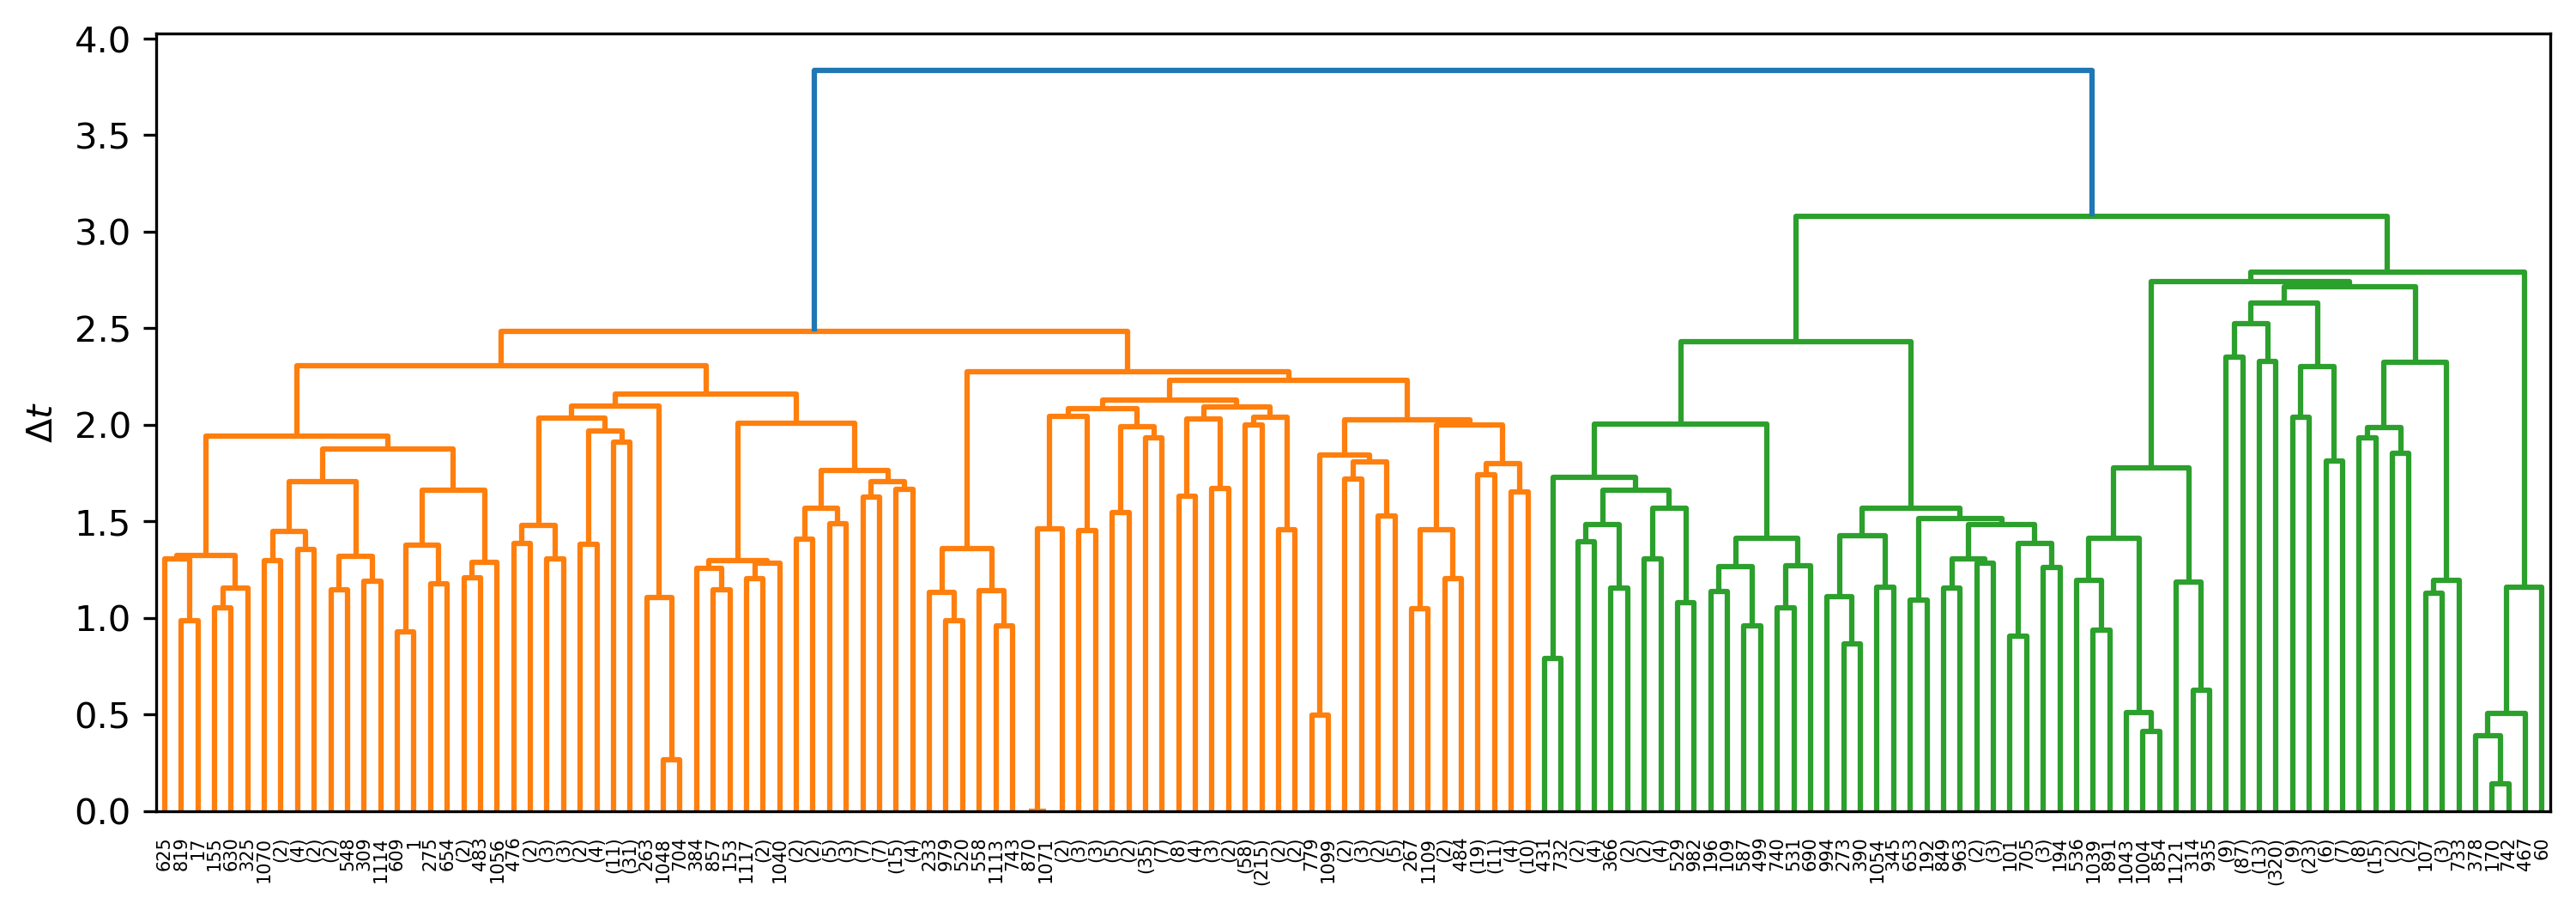

In [15]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
dn = dendrogram(Z, truncate_mode='level', color_threshold=3.5, p=7, ax=ax)
ax.set_ylabel(r'$\Delta t$');

To better visualize the $\Delta$ from the dendrogram, we can construct an elbow plot that represents the change in the value of $t$ as the number of clusters increases.

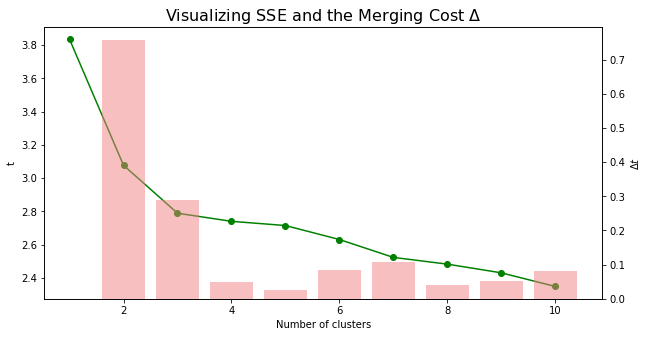

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, 11), np.sort(Z[:, 2])[::-1][:10], marker='o', color='green',
        label='SSE')
ax.set_ylabel('t')
ax.set_xlabel('Number of clusters')
ax.set_title(r'Visualizing SSE and the Merging Cost $\Delta$', fontsize=16)
ax2 = ax.twinx()
ax2.bar(range(2, 11), abs(np.diff(np.sort(Z[:, 2])[::-1][:10])),
        color='lightcoral', alpha=0.5, label=r'$\Delta t$')
ax2.set_ylabel(r'$\Delta t$')
plt.show()

We can also use other internal validation criteria such as the Calinski-Harabasz Score and the Silhouette score to determine the optimal number of clusters.

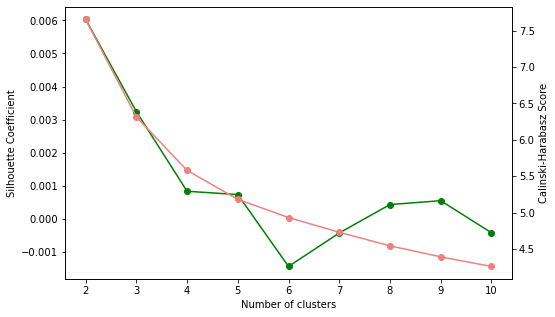

In [17]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering
chs = []
scs = []
k_start = 2
k_stop = 10

for k in range(k_start, k_stop+1):
    agg = AgglomerativeClustering(n_clusters=k)
    y_predict_ng = agg.fit_predict(X_ng_new)
    scs.append(silhouette_score(X_ng_new, y_predict_ng))
    chs.append(calinski_harabasz_score(X_ng_new, y_predict_ng))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(k_start, k_stop+1)), scs, color='green', marker='o',
        label='Silhouette Coefficient')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Coefficient')
ax2 = ax.twinx()
ax2.plot(list(range(k_start, k_stop+1)), chs, color='lightcoral', marker='o',
         label='Calinski-Harabasz Score')
ax2.set_ylabel('Calinski-Harabasz Score')
plt.show()

We visualize the clusters on the first two singular values, using a value of `t = 3.5`.

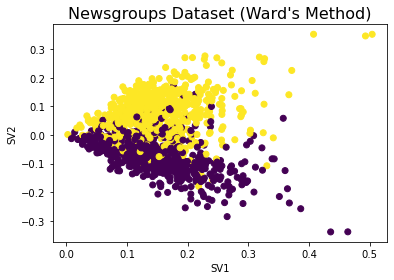

In [18]:
y_predict_ng = fcluster(Z, t=3.5, criterion='distance')
plt.scatter(X_ng_new[:, 0], X_ng_new[:, 1], c=y_predict_ng)
plt.xlabel('SV1')
plt.ylabel('SV2')
plt.title('Newsgroups Dataset (Ward\'s Method)', fontsize=16)
plt.show()

In [19]:
# summary statistics

cluster_results = pd.DataFrame({'cluster': np.unique(y_predict_ng),
                                'num_elements': np.bincount(y_predict_ng)[1:],
                                'dendrogram_color': ['orange', 'green']})
cluster_results

,cluster,num_elements,dendrogram_color
0,1,562,orange
1,2,566,green


From the elbow plot above, we see that the largest merging cost takes place when the number of clusters equals 2.
Likewise, the Silhouette Coefficient is closest to 0.5 when the number of clusters equals 2 and the Calinski-Harabasz Score is at its highest when the number of clusters equals 2. Hence, the optimal number of clusters for the newsgroups dataset is equal to 2. 

When assigning two clusters to the newsgroups dataset, there were 562 observations assigned to the first cluster and 566 clusters assigned to the second cluster.

## Single linkage

Single linkage uses the smallest intercluster distance as the metric. Let's try it on the wines dataset.

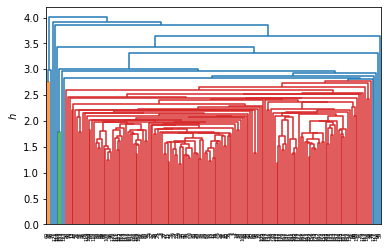

In [20]:
Z = linkage(X_wine, method='single', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$h$');

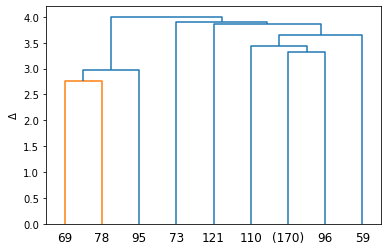

In [21]:
plot1(Z);

This will be the clustering if we set the threshold to 3.

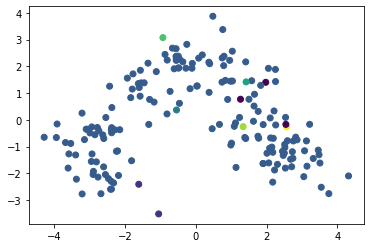

In [22]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=3, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 16**

Why is the clustering worse than with Ward's method?

The clustering under single linkage is worse than with Ward's method as the single linkage method is sensitive to noisy data or outliers. The single linkage method tends to face the chaining problem, as two clusters will merge even if there is one pair of points among each cluster that is close to one another, irrespective
of all others. Under the single linkage method, clusters may be too spread out or not compact enough.

**Exercise 17**

Cluster the newsgroups dataset using single linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

In order to be able to perform clustering, we first perform latent semantic analysis on the resulting bag of words data matrix to decompose bow_ng and perform agglomerative clustering on the transformed dataset.

Note that the first 722 singular values explain 90% of the variation in the resulting tf-idf matrix of the newsgroups dataset. For this exercise, we perform clustering on the first 1000 singular values.

In [23]:
ng_svd = TruncatedSVD(n_components=1000, random_state=1337)
X_ng_new = ng_svd.fit_transform(bow_ng)

We now perform agglomerative clustering on the transformed matrix.

In [24]:
Z = linkage(X_ng_new, method='single', optimal_ordering=True)

Once we form the linkages, we visualize the resulting dendrogram after performing agglomerative clustering using the single linkage method.

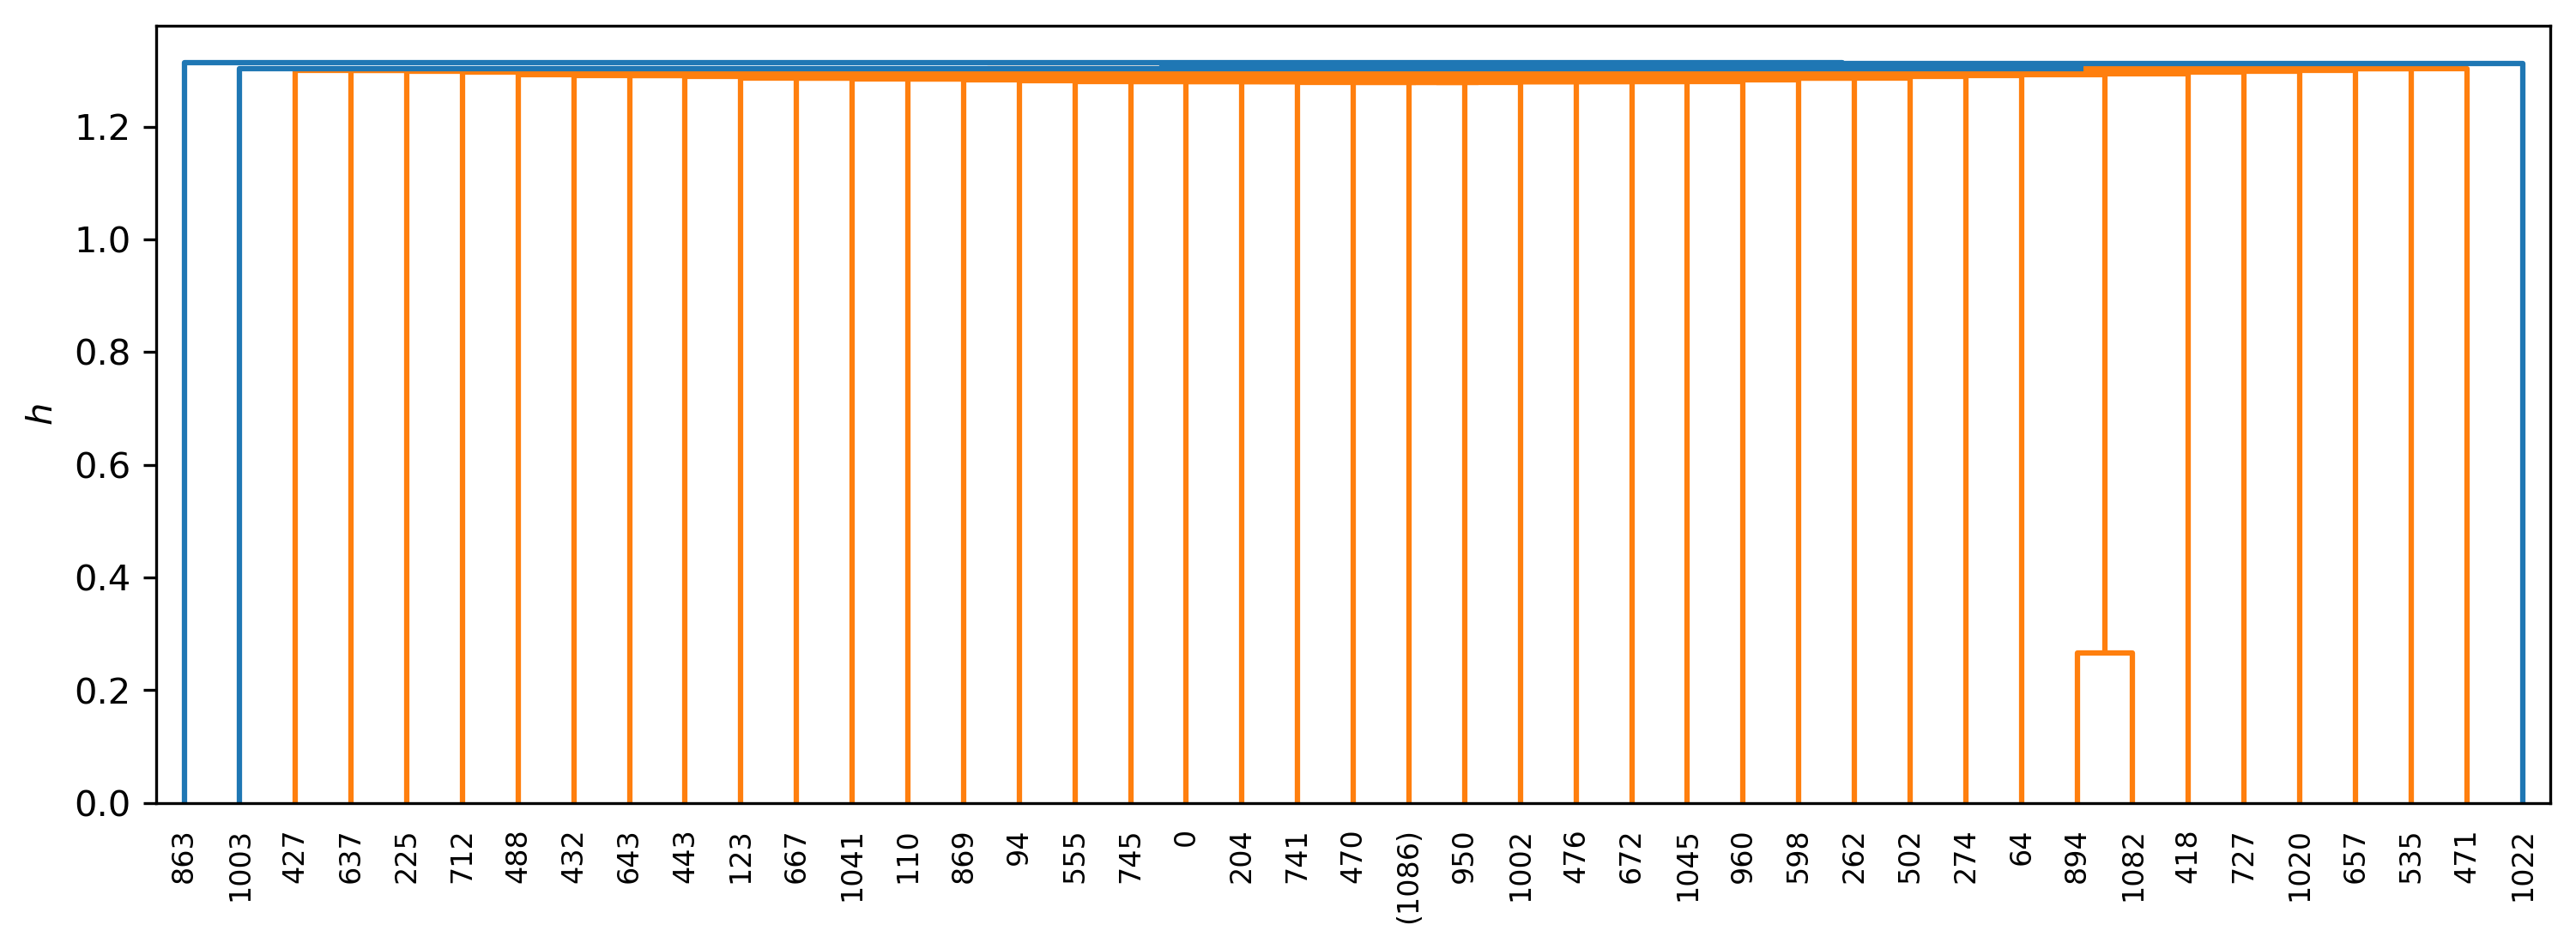

In [25]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
dn = dendrogram(Z, truncate_mode='level', color_threshold=1.3030, p=40, ax=ax)
ax.set_ylabel(r'$h$');

To better visualize the  $\Delta h$  from the dendrogram, we can construct an elbow plot that represents the change in the value of  $h$  as the number of clusters increases.

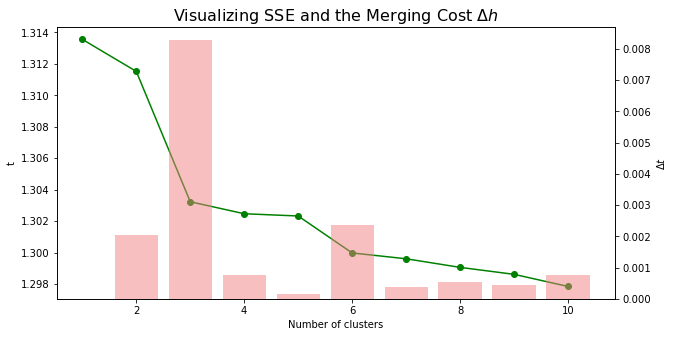

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, 11), np.sort(Z[:, 2])[::-1][:10], marker='o', color='green',
        label='SSE')
ax.set_ylabel('t')
ax.set_xlabel('Number of clusters')
ax.set_title(r'Visualizing SSE and the Merging Cost $\Delta h$', fontsize=16)
ax2 = ax.twinx()
ax2.bar(range(2, 11), abs(np.diff(np.sort(Z[:, 2])[::-1][:10])),
        color='lightcoral', alpha=0.5, label=r'$\Delta h$')
ax2.set_ylabel(r'$\Delta t$')
plt.show()

We can also use other internal validation criteria such as the Calinski-Harabasz Score and the Silhouette score to determine the optimal number of clusters.

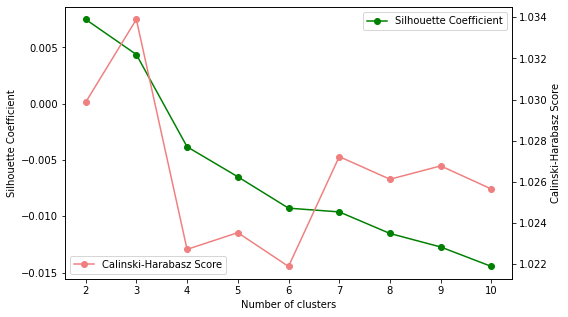

In [27]:
chs = []
scs = []
k_start = 2
k_stop = 10

for k in range(k_start, k_stop+1):
    agg = AgglomerativeClustering(n_clusters=k, linkage='single')
    y_predict_ng = agg.fit_predict(X_ng_new)
    scs.append(silhouette_score(X_ng_new, y_predict_ng))
    chs.append(calinski_harabasz_score(X_ng_new, y_predict_ng))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(k_start, k_stop+1)), scs, color='green', marker='o',
        label='Silhouette Coefficient')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Coefficient')
ax.legend(loc=1)
ax2 = ax.twinx()
ax2.plot(list(range(k_start, k_stop+1)), chs, color='lightcoral', marker='o',
         label='Calinski-Harabasz Score')
ax2.set_ylabel('Calinski-Harabasz Score')
ax2.legend(loc=3)
plt.show()

We visualize the clusters on the first two singular values, defining the number of clusters equal to 3 as deemed optimal by the SSE and the Calinski-Harabasz score.

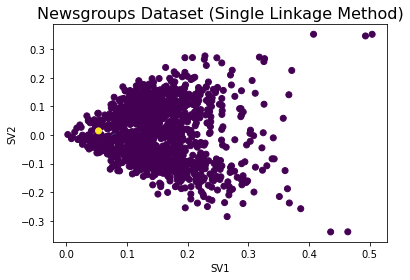

In [28]:
agg = AgglomerativeClustering(n_clusters=3, linkage='single')
y_predict_ng = agg.fit_predict(X_ng_new)
plt.scatter(X_ng_new[:, 0], X_ng_new[:, 1], c=y_predict_ng)
plt.xlabel('SV1')
plt.ylabel('SV2')
plt.title('Newsgroups Dataset (Single Linkage Method)', fontsize=16)
plt.show()

In [29]:
# summary statistics

cluster_results = pd.DataFrame({'cluster': np.unique(y_predict_ng),
                                'num_elements': np.bincount(y_predict_ng)})
cluster_results

,cluster,num_elements
0,0,1126
1,1,1
2,2,1


From the elbow plot above, we see that the largest merging cost takes place when the number of clusters equals 3. Likewise, the Calinski-Harabasz Score is at its highest when the number of clusters equals 3. Hence, the optimal number of clusters for the newsgroups dataset when using the single linkage method for agglomerative clustering is equal to 3. However, the Silhouette Coefficient is closest to 0.5 when the number of clusters equals 2 even under the single linkage method.

When assigning three clusters to the newsgroups dataset, there are 1126 observations assigned to the first cluster, 1 observation assigned to the second cluster, and 1 observation for the third cluster.

## Complete linkage

Complete linkage uses the largest intercluster distance as the metric. Let's try it on the wines dataset.

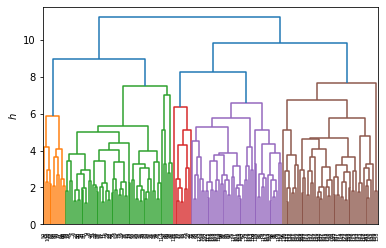

In [30]:
Z = linkage(X_wine, method='complete', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$h$');

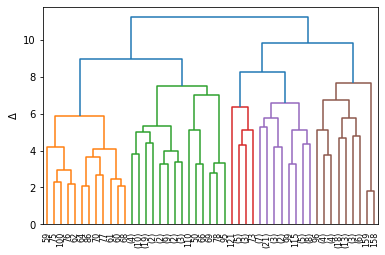

In [31]:
plot1(Z);

This will be the clustering if we set the threshold to 9.

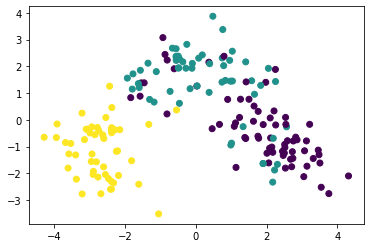

In [32]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=9, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 18**

Compare the clustering with those of Ward's method and single linkage. Is complete linkage better or worse than other methods?

We can visualize the clustering of Ward's method, the Single linkage method and the Complete linkage method relative to the ground truth labels of the wine dataset.

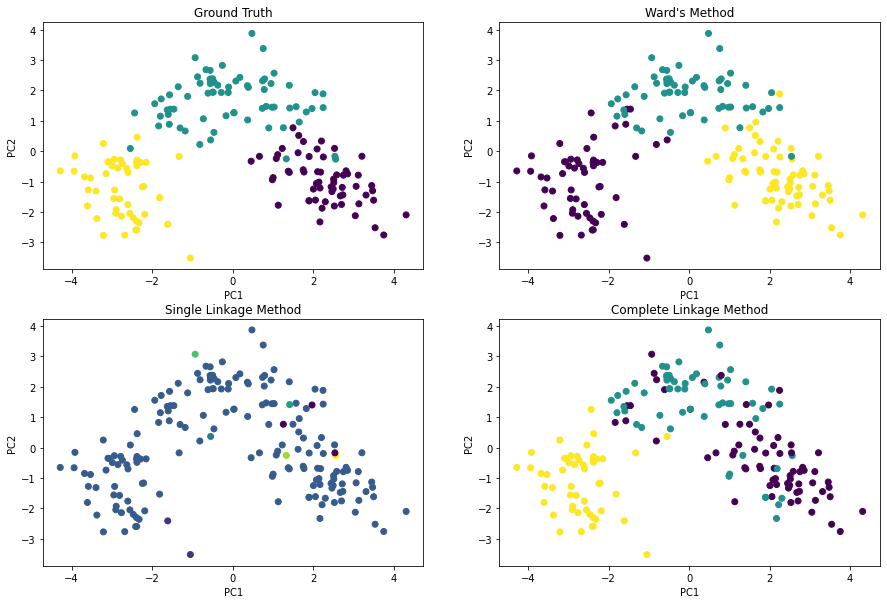

In [33]:
X_wine_new = PCA(n_components=2, random_state=1337).fit_transform(X_wine)

Z_ward = linkage(X_wine, method='ward', optimal_ordering=True)
y_predict_wine_ward = fcluster(Z_ward, t=25, criterion='distance')
Z_single = linkage(X_wine, method='single', optimal_ordering=True)
y_predict_wine_single = fcluster(Z_single, t=3, criterion='distance')
Z_complete = linkage(X_wine, method='complete', optimal_ordering=True)
y_predict_wine_complete = fcluster(Z_complete, t=9, criterion='distance')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax = ax.flatten()
clustering_results = [target_wine, y_predict_wine_ward,
                      y_predict_wine_single, y_predict_wine_complete]
titles = ['Ground Truth', 'Ward\'s Method',
          'Single Linkage Method', 'Complete Linkage Method']

for i, data in enumerate(zip(clustering_results, titles)):
    ax[i].scatter(X_wine_new[:, 0], X_wine_new[:, 1], c=data[0])
    ax[i].set_title(data[1])
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')

We can also look at external validation metrics to evaluate the clustering.

In [34]:
# looking at external validation criteria

from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score


def purity(y_true, y_pred):
    """Compute the class purity

    Parameters
    ----------
    y_true : array
        List of ground-truth labels
    y_pred : array
        Cluster labels

    Returns
    -------
    purity : float
        Class purity
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    return sum(np.max(conf_matrix, axis=0)) / np.sum(conf_matrix)


ps = []
amis = []
ars = []
clustering_predictions = [y_predict_wine_ward,
                          y_predict_wine_single, y_predict_wine_complete]
titles = ['Ward\'s Method',
          'Single Linkage Method', 'Complete Linkage Method']
actual = target_wine
for y in clustering_predictions:
    ps.append(purity(actual, y))
    amis.append(adjusted_mutual_info_score(actual, y))
    ars.append(adjusted_rand_score(actual, y))

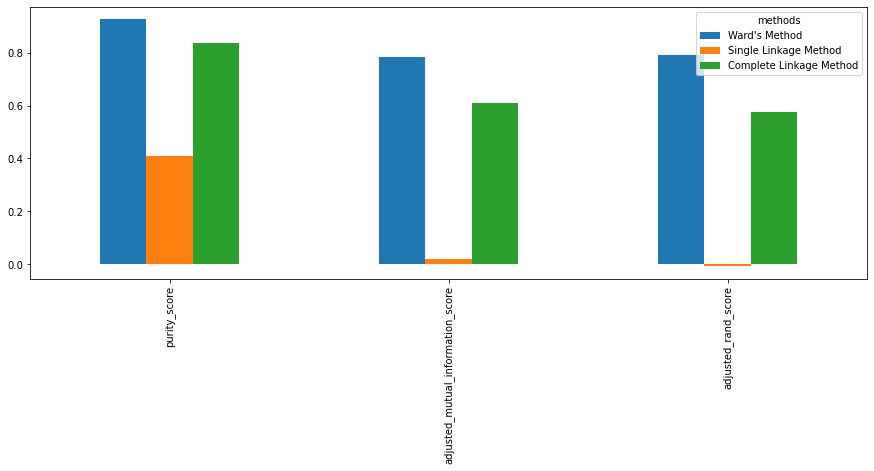

In [35]:
titles = ['Ward\'s Method',
          'Single Linkage Method', 'Complete Linkage Method']
ext_validation = pd.DataFrame({'methods': titles, 'purity_score': ps,
                               'adjusted_mutual_information_score': amis,
                               'adjusted_rand_score': ars})
ext_validation = ext_validation.set_index('methods').T
ext_validation.plot(kind='bar', figsize=(15, 5));

From the visualizations above, we could see that the clustering done using the Ward's method is closer to the ground truth labels of each datapoint in the wine dataset. This is also reflected with high scores on the external validation metrics, as the Ward's method got the highest purity score, adjusted mutual information score, and adjusted rand index out of all methods employed.

The clustering of complete linkage is significantly better than the single linkage method, since the results clustering performed from complete linkage is relatively close to the ground truth labels. However, the complete linkage method does not create much of a distinction between the blue green and violet cluster (as seen in the graph). The complete linkage method also scored the second highest in terms of all the external validation criteria used.

The single linkage method performs really bad in clustering the wines dataset, as it could not create a distinction among the three ground truth clusters. The single linkage method also scored the lowest in all external validation metrics employed.

**Exercise 19**

Cluster the newsgroups dataset using complete linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

In order to be able to perform clustering, we first perform latent semantic analysis on the resulting bag of words data matrix to decompose bow_ng and perform agglomerative clustering on the transformed dataset.

Note that the first 722 singular values explain 90% of the variation in the resulting tf-idf matrix of the newsgroups dataset. For this exercise, we perform clustering on the first 1000 singular values.

In [36]:
ng_svd = TruncatedSVD(n_components=1000, random_state=1337)
X_ng_new = ng_svd.fit_transform(bow_ng)

We now perform agglomerative clustering on the transformed matrix.

In [37]:
Z = linkage(X_ng_new, method='complete', optimal_ordering=True)

Once we form the linkages, we visualize the resulting dendrogram after performing agglomerative clustering using the complete linkage method.

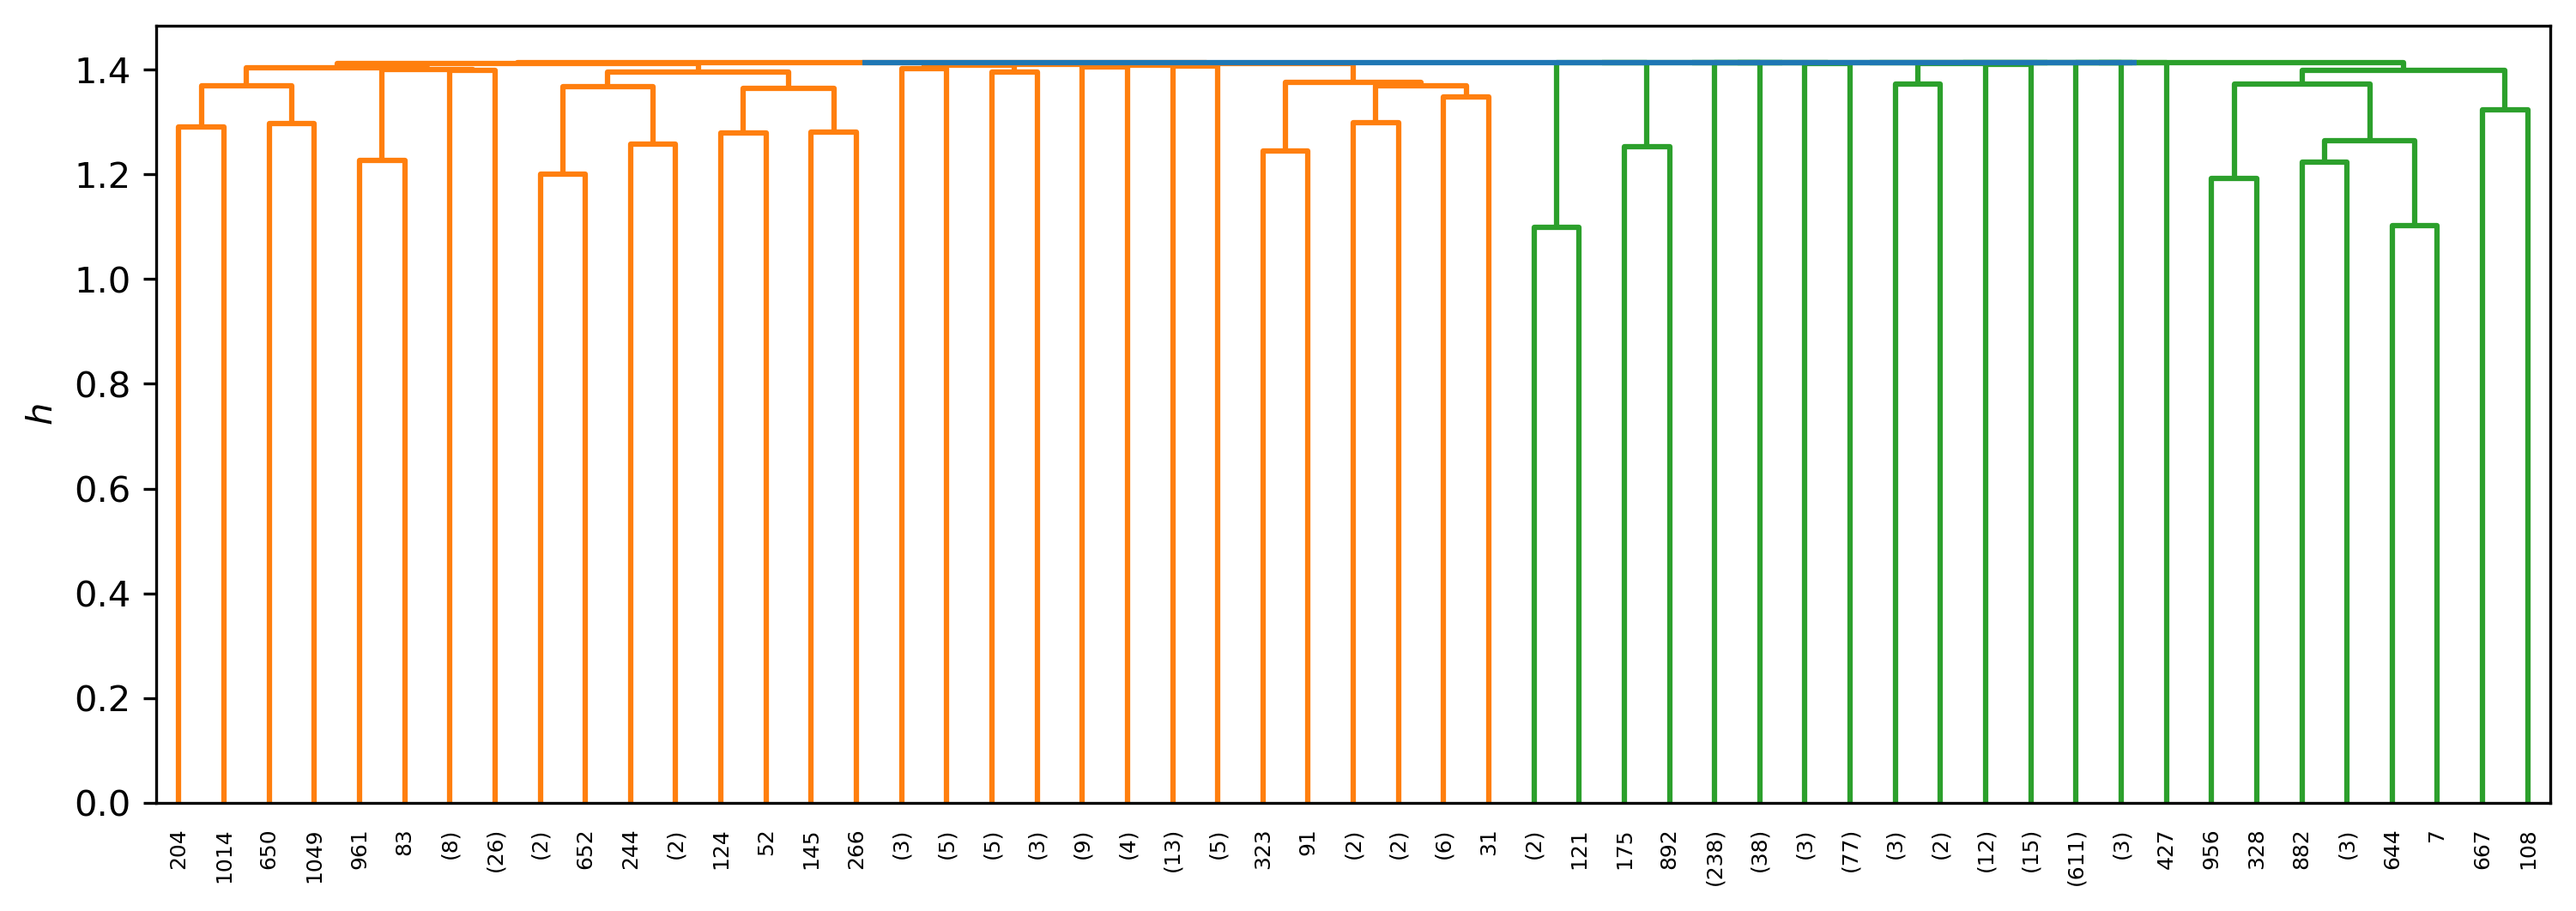

In [38]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
dn = dendrogram(Z, truncate_mode='level', color_threshold=1.4136, p=5, ax=ax)
ax.set_ylabel(r'$h$');

To better visualize the  Δℎ  from the dendrogram, we can construct an elbow plot that represents the change in the value of  ℎ  as the number of clusters increases.

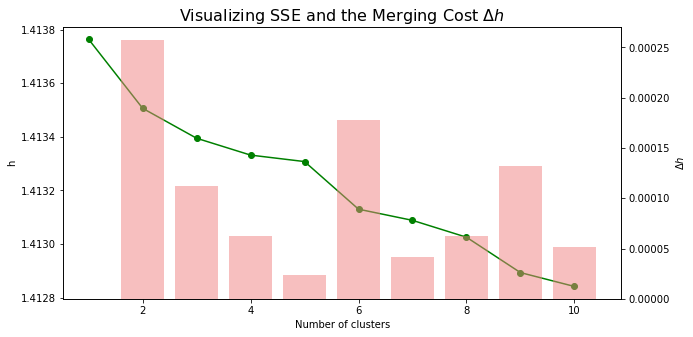

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, 11), np.sort(Z[:, 2])[::-1][:10], marker='o', color='green',
        label='SSE')
ax.set_ylabel('h')
ax.set_xlabel('Number of clusters')
ax.set_title(r'Visualizing SSE and the Merging Cost $\Delta h$', fontsize=16)
ax2 = ax.twinx()
ax2.bar(range(2, 11), abs(np.diff(np.sort(Z[:, 2])[::-1][:10])),
        color='lightcoral', alpha=0.5, label=r'$\Delta h$')
ax2.set_ylabel(r'$\Delta h$')
plt.show()

We can also use other internal validation criteria such as the Calinski-Harabasz Score and the Silhouette score to determine the optimal number of clusters.

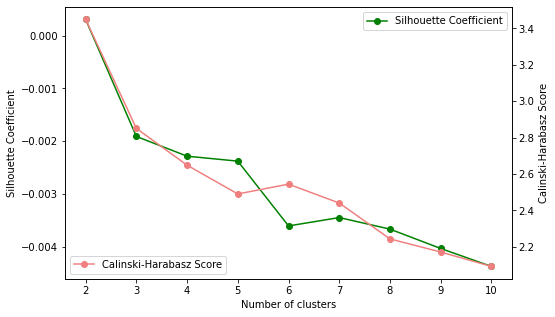

In [40]:
chs = []
scs = []
k_start = 2
k_stop = 10

for k in range(k_start, k_stop+1):
    agg = AgglomerativeClustering(n_clusters=k, linkage='complete')
    y_predict_ng = agg.fit_predict(X_ng_new)
    scs.append(silhouette_score(X_ng_new, y_predict_ng))
    chs.append(calinski_harabasz_score(X_ng_new, y_predict_ng))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(k_start, k_stop+1)), scs, color='green', marker='o',
        label='Silhouette Coefficient')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Coefficient')
ax.legend(loc=1)
ax2 = ax.twinx()
ax2.plot(list(range(k_start, k_stop+1)), chs, color='lightcoral', marker='o',
         label='Calinski-Harabasz Score')
ax2.set_ylabel('Calinski-Harabasz Score')
ax2.legend(loc=3)
plt.show()

We visualize the clusters on the first two singular values, defining the number of clusters equal to 2 as deemed optimal by the SSE, Calinski-Harabasz score and the Silhouette coefficient.

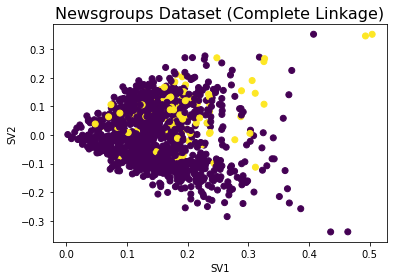

In [41]:
agg = AgglomerativeClustering(n_clusters=2, linkage='complete')
y_predict_ng = agg.fit_predict(X_ng_new)
plt.scatter(X_ng_new[:, 0], X_ng_new[:, 1], c=y_predict_ng)
plt.xlabel('SV1')
plt.ylabel('SV2')
plt.title('Newsgroups Dataset (Complete Linkage)', fontsize=16)
plt.show()

In [42]:
cluster_results = pd.DataFrame({'cluster': np.unique(y_predict_ng),
                                'num_elements': np.bincount(y_predict_ng)})
cluster_results

,cluster,num_elements
0,0,1018
1,1,110


From the elbow plot above, we see that the largest merging cost takes place when the number of clusters equals 2. Likewise, the Silhouette Coefficient is closest to 0.5 when the number of clusters equals 2 and the Calinski-Harabasz Score is at its highest when the number of clusters equals 2. Hence, the optimal number of clusters for the newsgroups dataset following the complete linkage method is equal to 2.

When assigning two clusters to the newsgroups dataset, there were 1018 observations assigned to the first cluster and 110 observations assigned to the second cluster.

## Average linkage

Average linkage uses the average intercluster distance as the metric. Let's try it on the wines dataset.

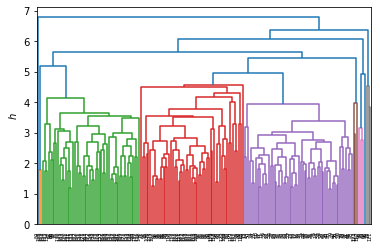

In [43]:
Z = linkage(X_wine, method='average', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, color_threshold=4.8, ax=ax)
ax.set_ylabel(r'$h$');

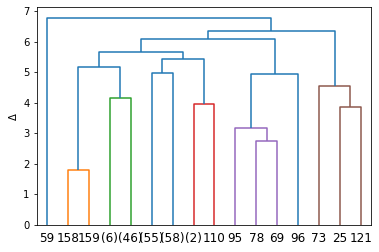

In [44]:
plot1(Z);

This will be the clustering if we set the threshold to 6.1, when we have three clusters.

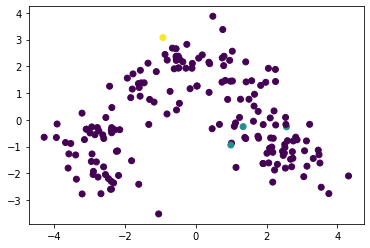

In [45]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=6.1, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 20**

Compare the clustering with those of Ward's method, single linkage and complete linkage. Is average linkage better or worse than other methods?

To be able to compare the clustering of average linkage relative to other methods, we visualize the predicted clusters of each method and compare it to the ground truth labels.

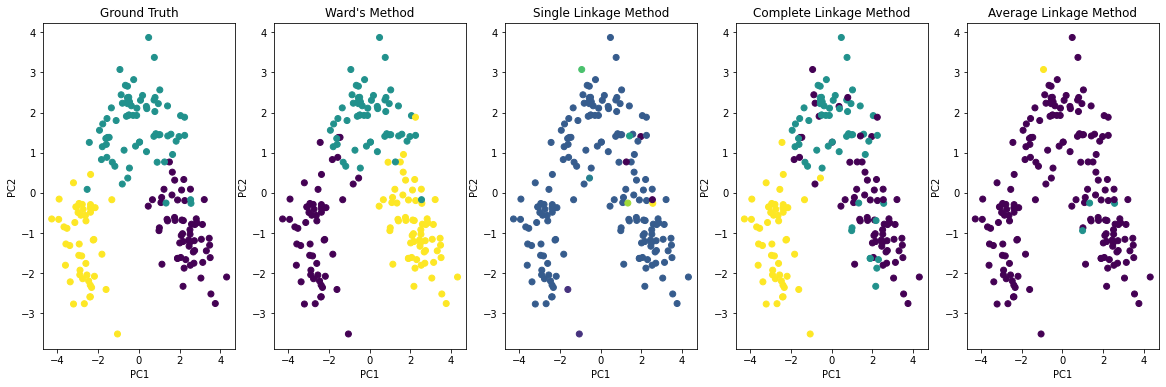

In [46]:
X_wine_new = PCA(n_components=2, random_state=1337).fit_transform(X_wine)

Z_ward = linkage(X_wine, method='ward', optimal_ordering=True)
y_predict_wine_ward = fcluster(Z_ward, t=25, criterion='distance')
Z_single = linkage(X_wine, method='single', optimal_ordering=True)
y_predict_wine_single = fcluster(Z_single, t=3, criterion='distance')
Z_complete = linkage(X_wine, method='complete', optimal_ordering=True)
y_predict_wine_complete = fcluster(Z_complete, t=9, criterion='distance')
Z_average = linkage(X_wine, method='average', optimal_ordering=True)
y_predict_wine_average = fcluster(Z_average, t=6.1, criterion='distance')
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
ax = ax.flatten()
clustering_results = [target_wine, y_predict_wine_ward,
                      y_predict_wine_single, y_predict_wine_complete,
                      y_predict_wine_average]
titles = ['Ground Truth', 'Ward\'s Method',
          'Single Linkage Method', 'Complete Linkage Method',
          'Average Linkage Method']

for i, data in enumerate(zip(clustering_results, titles)):
    ax[i].scatter(X_wine_new[:, 0], X_wine_new[:, 1], c=data[0])
    ax[i].set_title(data[1])
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')

We can also look at external validation criteria to evaluate the clustering models implemented.

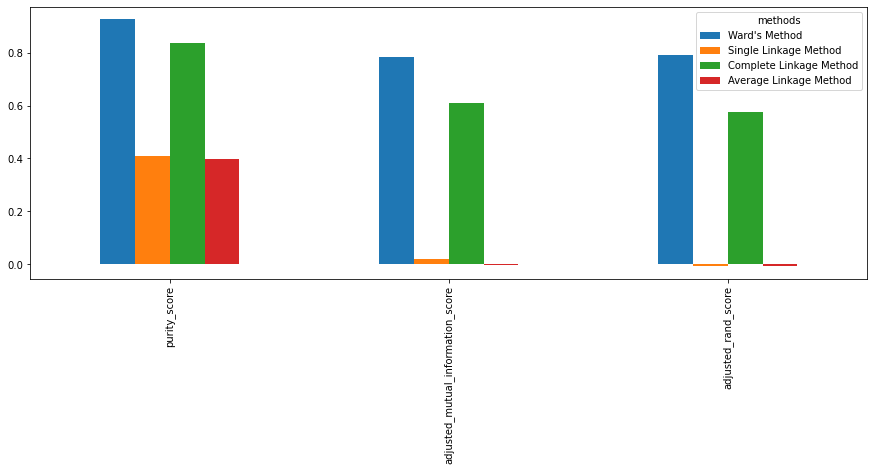

In [47]:
# looking at external validation criteria

ps = []
amis = []
ars = []
clustering_predictions = [y_predict_wine_ward,
                          y_predict_wine_single, y_predict_wine_complete,
                          y_predict_wine_average]
titles = ['Ward\'s Method',
          'Single Linkage Method', 'Complete Linkage Method',
          'Average Linkage Method']
actual = target_wine
for y in clustering_predictions:
    ps.append(purity(actual, y))
    amis.append(adjusted_mutual_info_score(actual, y))
    ars.append(adjusted_rand_score(actual, y))

ext_validation = pd.DataFrame({'methods': titles, 'purity_score': ps,
                               'adjusted_mutual_information_score': amis,
                               'adjusted_rand_score': ars})
ext_validation = ext_validation.set_index('methods').T
ext_validation.plot(kind='bar', figsize=(15, 5));

For the wine dataset, the average linkage method performed as badly as the single linkage method in identifying the correct clusters. Out of all four methods, the Ward's method performs the best in clustering the data and it is consistent with the ground truth labels. The Ward's method also has the highest score in all external validation criteria. Following the Ward's method, the complete linkage method does a relatively good job in assigning clusters to each observation. The average linkage method has the lowest purity score, adjusted mutual information score, and adjusted rand index among all agglomerative clustering methods used.

**Exercise 21**

Cluster the newsgroups dataset using average linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

In order to be able to perform clustering, we first perform latent semantic analysis on the resulting bag of words data matrix to decompose bow_ng and perform agglomerative clustering on the transformed dataset.

Note that the first 722 singular values explain 90% of the variation in the resulting tf-idf matrix of the newsgroups dataset. For this exercise, we perform clustering on the first 1000 singular values.

In [48]:
ng_svd = TruncatedSVD(n_components=1000, random_state=1337)
X_ng_new = ng_svd.fit_transform(bow_ng)

We now perform agglomerative clustering on the transformed matrix.

In [49]:
Z = linkage(X_ng_new, method='average', optimal_ordering=True)

Once we form the linkages, we visualize the resulting dendrogram after performing agglomerative clustering using the average linkage method.

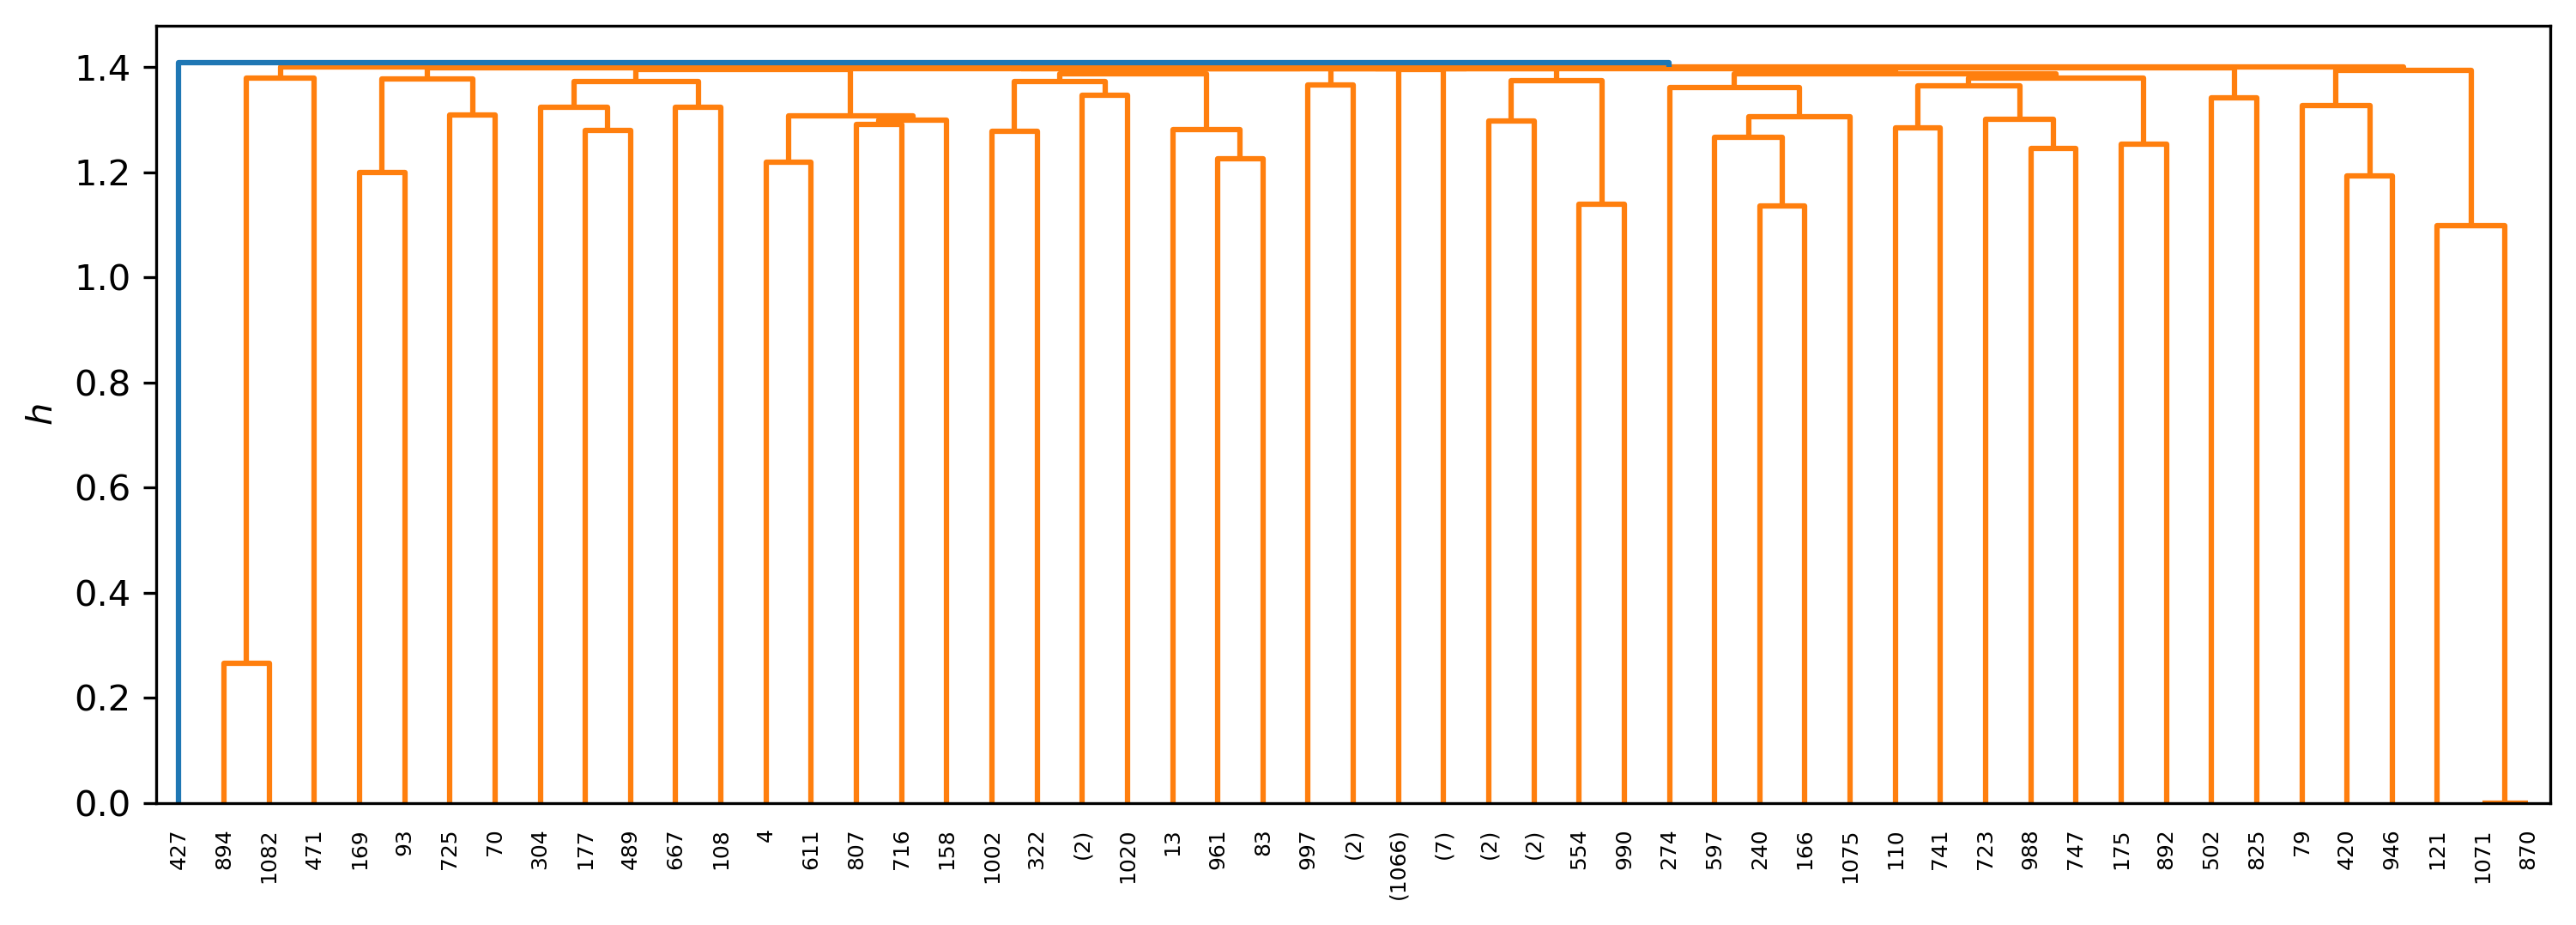

In [50]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
dn = dendrogram(Z, truncate_mode='level', color_threshold=1.401, p=10, ax=ax)
ax.set_ylabel(r'$h$');

To better visualize the Δℎ from the dendrogram, we can construct an elbow plot that represents the change in the value of ℎ as the number of clusters increases.

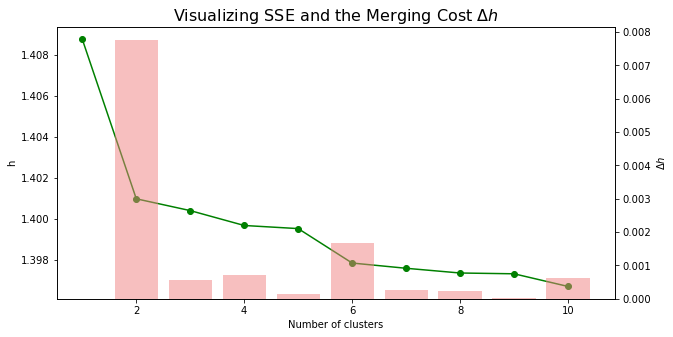

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, 11), np.sort(Z[:, 2])[::-1][:10], marker='o', color='green',
        label='SSE')
ax.set_ylabel('h')
ax.set_xlabel('Number of clusters')
ax.set_title(r'Visualizing SSE and the Merging Cost $\Delta h$', fontsize=16)
ax2 = ax.twinx()
ax2.bar(range(2, 11), abs(np.diff(np.sort(Z[:, 2])[::-1][:10])),
        color='lightcoral', alpha=0.5, label=r'$\Delta h$')
ax2.set_ylabel(r'$\Delta h$')
plt.show()

We can also use other internal validation criteria such as the Calinski-Harabasz Score and the Silhouette score to determine the optimal number of clusters.

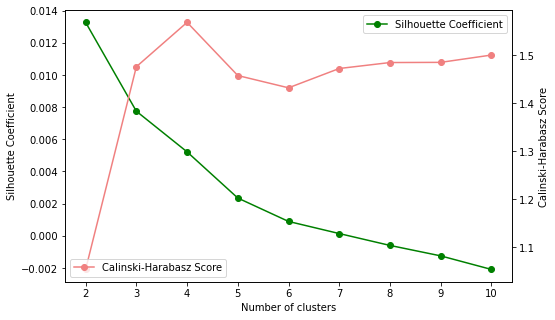

In [52]:
chs = []
scs = []
k_start = 2
k_stop = 10

for k in range(k_start, k_stop+1):
    agg = AgglomerativeClustering(n_clusters=k, linkage='average')
    y_predict_ng = agg.fit_predict(X_ng_new)
    scs.append(silhouette_score(X_ng_new, y_predict_ng))
    chs.append(calinski_harabasz_score(X_ng_new, y_predict_ng))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(k_start, k_stop+1)), scs, color='green', marker='o',
        label='Silhouette Coefficient')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Coefficient')
ax.legend(loc=1)
ax2 = ax.twinx()
ax2.plot(list(range(k_start, k_stop+1)), chs, color='lightcoral', marker='o',
         label='Calinski-Harabasz Score')
ax2.set_ylabel('Calinski-Harabasz Score')
ax2.legend(loc=3)
plt.show()

We visualize the clusters on the first two singular values, defining the number of clusters equal to 2 as deemed optimal by the SSE and the Silhouette coefficient.

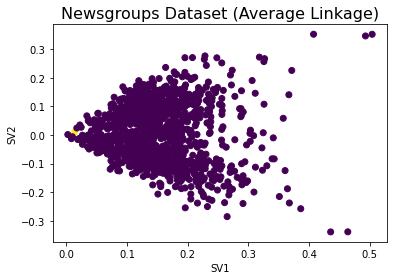

In [53]:
agg = AgglomerativeClustering(n_clusters=2, linkage='average')
y_predict_ng = agg.fit_predict(X_ng_new)
plt.scatter(X_ng_new[:, 0], X_ng_new[:, 1], c=y_predict_ng)
plt.xlabel('SV1')
plt.ylabel('SV2')
plt.title('Newsgroups Dataset (Average Linkage)', fontsize=16)
plt.show()

In [54]:
# summary statistics

cluster_results = pd.DataFrame({'cluster': np.unique(y_predict_ng),
                                'num_elements': np.bincount(y_predict_ng)})
cluster_results

,cluster,num_elements
0,0,1127
1,1,1


From the elbow plot above, we see that the largest merging cost takes place when the number of clusters equals 2. Likewise, the Silhouette Coefficient is closest to 0.5 when the number of clusters equals 2. Hence, the optimal number of clusters for the newsgroups dataset when using the average linkage method for agglomerative clustering is equal to 2. However, the Calinski-Harabasz Score is closest to 0.5 when the number of clusters equals 4 even under the average linkage method.

When assigning two clusters to the newsgroups dataset, there are 1127 observations assigned to the first cluster and only 1 observation assigned to the second cluster.

Now that we have performed the different methods of agglomerative clustering on the newsgroups dataset, we visualize the predicted clusters of each method and compare it to the ground truth labels.

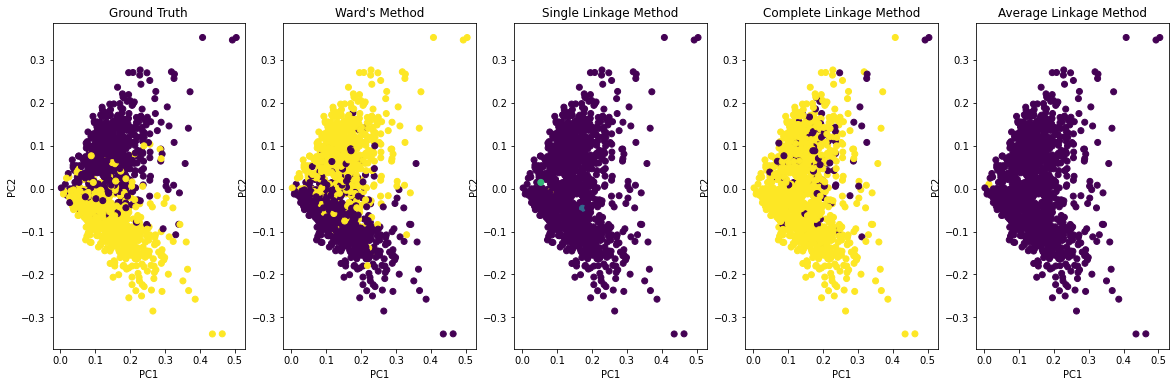

In [55]:
ng_svd = TruncatedSVD(n_components=1000, random_state=1337)
X_ng_new = ng_svd.fit_transform(bow_ng)

Z_ward = linkage(X_ng_new, method='ward', optimal_ordering=True)
y_predict_ng_ward = fcluster(Z_ward, t=3.5, criterion='distance')
Z_single = linkage(X_ng_new, method='single', optimal_ordering=True)
y_predict_ng_single = fcluster(Z_single, t=1.3030, criterion='distance')
Z_complete = linkage(X_ng_new, method='complete', optimal_ordering=True)
y_predict_ng_complete = fcluster(Z_complete, t=1.4136, criterion='distance')
Z_average = linkage(X_ng_new, method='average', optimal_ordering=True)
y_predict_ng_average = fcluster(Z_average, t=1.401, criterion='distance')
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
ax = ax.flatten()
clustering_results = [target_ng, y_predict_ng_ward,
                      y_predict_ng_single, y_predict_ng_complete,
                      y_predict_ng_average]
titles = ['Ground Truth', 'Ward\'s Method',
          'Single Linkage Method', 'Complete Linkage Method',
          'Average Linkage Method']

for i, data in enumerate(zip(clustering_results, titles)):
    ax[i].scatter(X_ng_new[:, 0], X_ng_new[:, 1], c=data[0])
    ax[i].set_title(data[1])
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')

We can also look at external validation criteria to evaluate the clustering models implemented.

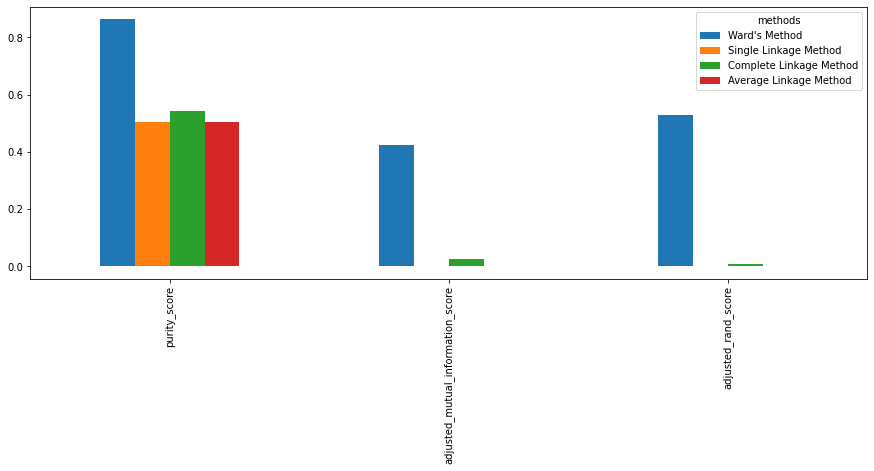

In [56]:
ps = []
amis = []
ars = []
clustering_predictions = [y_predict_ng_ward,
                          y_predict_ng_single, y_predict_ng_complete,
                          y_predict_ng_average]
titles = ['Ward\'s Method',
          'Single Linkage Method', 'Complete Linkage Method',
          'Average Linkage Method']
actual = target_ng
for y in clustering_predictions:
    ps.append(purity(actual, y))
    amis.append(adjusted_mutual_info_score(actual, y))
    ars.append(adjusted_rand_score(actual, y))

ext_validation = pd.DataFrame({'methods': titles, 'purity_score': ps,
                               'adjusted_mutual_information_score': amis,
                               'adjusted_rand_score': ars})
ext_validation = ext_validation.set_index('methods').T
ext_validation.plot(kind='bar', figsize=(15, 5));

For the newsgroups dataset, the average linkage method performed as badly as the single linkage method in identifying the correct clusters. Out of all four methods, the Ward's method performs the best in clustering the data and it is consistent with the ground truth labels. The Ward's method also has the highest score in all external validation criteria. 

# References
* C. Shalizi, Statistics 36-350 lecture notes, http://www.stat.cmu.edu/~cshalizi/350/lectures/07/lecture-07.pdf
* C. Aggarwal, Data Mining: The Textbook, Chapter 6.